In [54]:
# Imports

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore', category = RuntimeWarning)
import os
import sklearn
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.datasets import make_classification
from numpy import unique
from numpy import where
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error
from scipy import stats

In [55]:
# Preparation of data:

#Import of the datatables
data_production = pd.read_csv("pv_production_new.csv")
data_location = pd.read_csv("pv_locations.csv")
data_weather = pd.read_csv("weather_data_juli.txt", sep=",", header=None)
data_weather = pd.DataFrame(data_weather.values[1:], columns=["Times","Irradiation"])
data_weather['Times'] = pd.to_datetime(data_weather['Times'])

# Data based on raining and not on irradiation
# Production prediction based on rain might be easier as there are rain predictions
# available for the upcoming days. But in our case it didn't work out that well, thats
# why we use the irradiation data as basis for our prediction
data_rain = pd.read_csv("rain_data.txt", sep=",", header=None)
data_rain = pd.DataFrame(data_rain.values[1:], columns=["Times","Temperature", "Precipitation"])
data_rain['Times'] = pd.to_datetime(data_rain['Times'])


# calculating the average irradiation per hour
#df_weather = [0]*30
#for d in range(30):
#    df_w = data_weather[d*12*24:(d+1)*12*24]
#    df_new = [0]*24
#    for i in range(24):
#        df_new[i] = np.mean(df_w[12*i:12*i+1]["Irradiation"])
#    df_weather[d] = df_new
    

# prepare weather data: irradiation per hour
df_weather_per_hour = [0]*720
df_time = [0]*720
counter = 0
for d in range(30):
    irradiation = data_weather[d*12*24:(d+1)*12*24]
    irradiation2 = data_weather[d*12*24:(d+1)*12*24]["Times"]
    for i in range(24):
        string_time = irradiation2[i*12:i*12+1].to_string(index=False)
        df_time[counter] = string_time
        df_weather_per_hour[counter] = np.mean(irradiation[12*i:12*i+1]["Irradiation"])
        counter = counter+1
        
        
# calculating the average rain per hour        
#df_rain = [0]*30
#for d in range(30):
#    df_w = data_rain[d*12*24:(d+1)*12*24]
#    df_new = [0]*24
#    for i in range(24):
#        df_new[i] = np.mean(df_w[12*i:12*i+1]["Precipitation"])
#    df_rain[d] = df_new
    

# prepare weather data: rain per hour
#df_rain_per_hour = [0]*720
#df_time = [0]*720
#counter = 0
#for d in range(30):
#    rain = data_rain[d*12*24:(d+1)*12*24]
#    rain2 = data_rain[d*12*24:(d+1)*12*24]["Times"]
#    for i in range(24):
#        string_time = rain2[i*12:i*12+1].to_string(index=False)
#        df_time[counter] = string_time
#        df_rain_per_hour[counter] = np.mean(rain[12*i:12*i+1]["Precipitation"])
#        counter = counter+1      
        

# prepare data: overall production per hour
df_prod_per_hour = [0]*720
counter = 0
for d in range(30):
    days = data_production[data_production["day"]==d+1]
    for h in range(24):
        df_prod_per_hour[counter] = sum(days[days["time"]== h+1].production)
        counter = counter+1 
        


# combine irradiation and production
d = {'time': df_time, 'production': df_prod_per_hour, 'irradiation': df_weather_per_hour }
df_prod_irr_per_h = pd.DataFrame(data=d)
df_prod_irr_per_h['time'] = pd.to_datetime(df_prod_irr_per_h['time'])


#df_prod_irr_per_h.to_csv('modified.csv')

In [56]:
# final test dataset: last day (24h) of dataset
# val and train for training and validation

test = df_prod_irr_per_h[696:720]
training = df_prod_irr_per_h[0:695]
train, val = train_test_split(training, random_state = 111, test_size=0.15)

score:  0.85088455946834
mse:  112.09812663549053


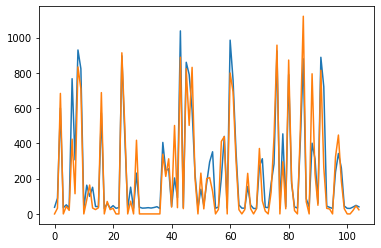

In [57]:
# Weather-prediction with linear regression 
lr = LinearRegression()
lr.fit(train[['irradiation']], train[['production']])
lr_score = lr.score(val[['irradiation']], val[['production']])

#Plot the vaidation-time
lr_predictions_val = lr.predict(val[['irradiation']])
val1_plot = np.array(val['production'])
plt.plot(lr_predictions_val)
plt.plot(val1_plot)

rmse = np.sqrt(mean_squared_error(val.production, lr.predict(val[['irradiation']])))
print('score: ', lr_score)
print('mse: ', rmse )

In [58]:
#Cross-Validation with Linear Regression
from sklearn.model_selection import cross_validate

cv_lr = cross_validate(lr, X=np.array(train['irradiation']).reshape(-1, 1), y=(train['production']), cv=9)
cv_lr['test_score']

print('average score: ', np.average(cv_lr['test_score']))

rmse = np.sqrt(mean_squared_error(val.production, lr.predict(val[['irradiation']])))
print('mse: ', rmse )

average score:  0.7906368304099499
mse:  112.09812663549053


score:  0.8645771385901337
mse:  106.82749379520482


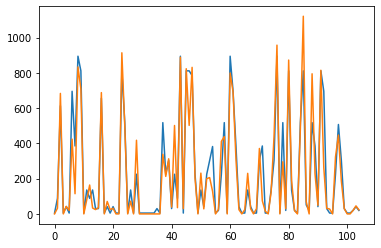

In [59]:
# Weather-prediction with decisionTreeRegressor
dtr=DecisionTreeRegressor(max_depth = 5)

dtr.fit(X = np.array(train.irradiation).reshape(-1, 1), y = train.production)

dtr_score = dtr.score(val[['irradiation']], val[['production']])
print('score: ', dtr_score)

rmse = np.sqrt(mean_squared_error(val.production, dtr.predict(np.array(val['irradiation']).reshape(-1, 1))))
print('mse: ', rmse )

# Plot the final day:
predictions_dtr = dtr.predict(np.array(val['irradiation']).reshape(-1, 1))
plt.plot(predictions_dtr)
plt.plot(val1_plot)

In [60]:
cv_dtr = cross_validate(dtr, X=np.array(train['irradiation']).reshape(-1, 1), y=train['production'], cv=25)
cv_dtr['test_score']

dtr_score = dtr.score(val[['irradiation']], val[['production']])
print('average score: ', np.average(cv_dtr['test_score']))

rmse = np.sqrt(mean_squared_error(val.production, dtr.predict(np.array(val['irradiation']).reshape(-1, 1))))
print('mse: ', rmse )
    

average score:  0.7620988735249109
mse:  106.82749379520482


In [61]:
# Overall Prediction based on DecisionTreeRegressor

def predict_overall_production(weatherdata):

    if len(weatherdata) == 0:
        df_w = test['irradiation']
    else: 
        df_w = weatherdata

    dtr=DecisionTreeRegressor(max_depth = 4)

    dtr.fit(X = np.array(train.irradiation).reshape(-1, 1), y = train.production)

    #dtr_score = dtr.score(val[['irradiation']], val[['production']])
    #print('The prediction has a score of: ', dtr_score)
    
    predictions_dtr = dtr.predict(np.array(df_w).reshape(-1, 1))
    plt.plot(predictions_dtr)
    
    original_prod = np.array(test['production'])
    plt.plot(original_prod)
                
    return predictions_dtr

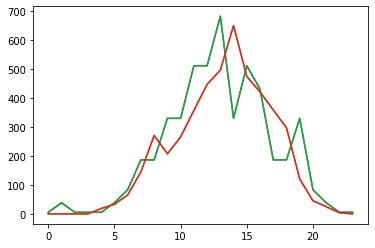

In [62]:
# Calculating the overall production

# example 1: Weatherdata as array with Irradiance values
prediction = predict_overall_production(test['irradiation'])

# example 2: Prediction based on example weatherdata
prediction = predict_overall_production('')

In [63]:
# Predict the production of one single household based on DecisionTreeRegressor

def predict_single_household_production_dtr(household, weatherdata):

    if len(weatherdata) == 0:
        df_w = test['irradiation']
    else: 
        df_w = weatherdata

    df_p = data_production[data_production["pv_id"]== household][:695].production
    
    dtr_single=DecisionTreeRegressor(max_depth = 4)

    dtr_single.fit(X = np.array(training.irradiation).reshape(-1, 1), y = df_p)

    predictions_dtr = dtr_single.predict(np.array(df_w).reshape(-1, 1))
    
    original_production = df_p = data_production[data_production["pv_id"]== household][695:719].production
    original_prod = np.array(original_production)
    
    # creating a 95% confidence interval
    sum_errs = np.sum((predictions_dtr - original_prod)**2)
    stdev = np.sqrt(1/(len(original_prod)-2) * sum_errs)
    # finding a 95% interval
    # z is 1.96 when we want there to be 95% certainty
    z = 1.96
    interval = z * stdev
    
    plt.errorbar(np.array(range(24)), predictions_dtr, yerr=interval, fmt='none', ecolor='b', capsize=2)
    plt.plot(predictions_dtr)
    plt.plot(original_prod)
    
    '''
    confidence = 0.95
    squared_errors = (predictions_dtr - original_prod) ** 2
    np.sqrt(stats.t.interval(confidence, len(squared_errors) - 1,
                             loc=squared_errors.mean(),
                             scale=stats.sem(squared_errors)))'''
    
    return predictions_dtr


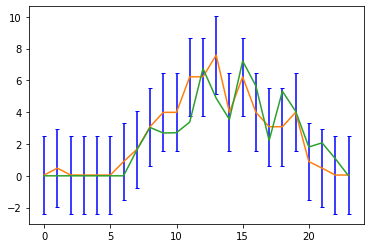

In [64]:
# example of single household predictions based on DecisionTreeRegressor
# Weatherdata has to be an array with 24 values of Irradiation

#prediction = predict_single_household_production(1, '')

prediction = predict_single_household_production_dtr(5, test['irradiation'])

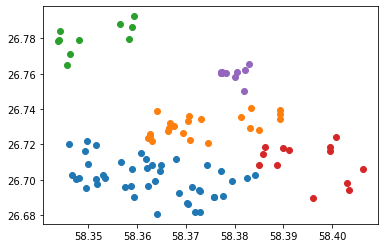

In [65]:
# cluster of household location 

d = {'latitude': data_location["latitude"], 'longitude': data_location["longitude"]}
df_loc = pd.DataFrame(data=d)

agg_clustering = AgglomerativeClustering(n_clusters=5).fit(df_loc)
labels = agg_clustering.labels_
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for row in range(100):
    plt.scatter(df_loc["latitude"][row],df_loc["longitude"][row], c=colours[labels[row]])
    
plt.show()

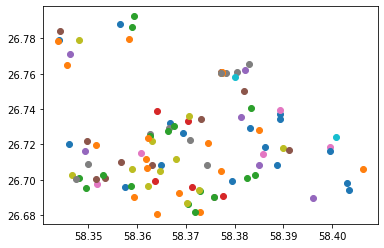

In [66]:
# daily production per household 

data_production.head()
df_prod = [0]*100
for i in range(100):
    df_prod[i] = data_production[data_production["pv_id"]==i]
    df_day = [0]*30
    for d in range(30):
        df_day[d] = np.sum(df_prod[i][df_prod[i]["day"]==d].production)
    df_prod[i] = np.sum(df_day)

# cluster of daily production per household (aggregative clustering)

d = {'latitude': data_location["latitude"], 'longitude': data_location["longitude"]}
df_loc = pd.DataFrame(data=d)

df_prod = np.reshape(df_prod, (-1, 1))
agg_clustering = AgglomerativeClustering(n_clusters=10).fit(df_prod)
labels = agg_clustering.labels_
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for row in range(100):
    plt.scatter(df_loc["latitude"][row],df_loc["longitude"][row], c=colours[labels[row]])
    
plt.show()